# CS375 - Assignment 2: Colorization model
This notebook contains results and analysis for the colorization model described the Zhang et al. Two versions of the model were trained, one using ImageNet and the other using CIFAR-10. Both models use one-hot encoding of the Q values rather than the soft encoding used by Zhang et al. In addition, class rebalancing is not used, which is apparent in the bias toward brown colors shown in the colorization examples at the bottom of this notebook.

In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

### Data and plotting functions
#### Training curve

In [2]:
def get_losses(exp_id, collname='small_model', dbname='test_db'):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def smooth(arr, size=300):
    return signal.convolve(arr, np.ones(size)/size, mode='valid')

def plt_reg_and_smoothed(arr, title_prefix):
    smoothed = smooth(arr)
    for values, title_suffix in zip([arr, smoothed], ['', ' Smoothed']):
        plt.plot(values)
        plt.title(title_prefix + title_suffix)
        plt.show()

#### Validation accuracy curve

In [3]:
def get_imagenet_validation_data(exp_id, collname='small_model', dbname='test_db'):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'step'])
    losses = [val_steps[i]['validation_results']['topn_val']['loss'] 
            for i in range(val_steps.count())]
    top1 = [val_steps[i]['validation_results']['topn_val'].get('top1', 0.0)
            for i in range(val_steps.count())]
    top5 = [val_steps[i]['validation_results']['topn_val'].get('top5', 0.0)
            for i in range(val_steps.count())]
    steps = [val_steps[i]['step'] for i in range(val_steps.count())]
    
    data = {}
    for i in range(val_steps.count()):
        data[steps[i]] = (losses[i], top1[i], top5[i])
    
    return data

def get_cifar_validation_data(exp_id, collname='small_model', dbname='test_db'):
    """
    Gets the validation data from the database (except for gridfs data)
    """
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'step'])
    losses = [val_steps[i]['validation_results']['valid0']['loss'] 
            for i in range(val_steps.count())]
    top1 = [val_steps[i]['validation_results']['valid0'].get('top1', 0.0)
            for i in range(val_steps.count())]
    top5 = [val_steps[i]['validation_results']['valid0'].get('top5', 0.0)
            for i in range(val_steps.count())]
    steps = [val_steps[i]['step'] for i in range(val_steps.count())]
    
    data = {}
    for i in range(val_steps.count()):
        data[steps[i]] = (losses[i], top1[i], top5[i])
    
    return data

def plot_accuracies(validation_results, title_prefix):
    steps = sorted(validation_results.keys())
    titles = ['Loss', 'Top 1', 'Top 5']
    for i in range(3):
        results = [ validation_results[step][i] for step in steps ]
        plt.plot(steps, results)
        plt.title(title_prefix + ': %s' % titles[i])
        plt.show()

#### Neural analysis functions

In [4]:
def get_neural_validation_data(exp_id, collname='alexnet', dbname=''):
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}, 
             'validation_results.neural' : {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    return results

def get_classification_validation_data(exp_id, collname='alexnet', dbname=''):
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}, 
             'validation_results.imagenet' : {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    return results

def get_colorization_validation_data(exp_id, collname='alexnet', dbname=''):
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}, 
             'validation_results.colorization' : {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    return results

def plot_rdms(data, target_layers, step, variation='all'):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    for i, layer in enumerate(target_layers):
        rdm_name = 'rdm_%s_%s' % (layer, variation)
        rdm = data[rdm_name]
        spearman_corrcoef = data['spearman_corrcoef_%s_%s' % (layer, variation)]
        ### YOUR CODE HERE
        m = plt.gca().matshow(rdm)
        plt.colorbar(m)
        plt.title(rdm_name + ': spearman_corr_coeff = {0:.5f}; step: {1}'.format(spearman_corrcoef, step))
        ax = plt.gca()
        ax.xaxis.tick_bottom()
        plt.show()        
        ### END OF YOUR CODE
        
def plot_categorization_results(data, target_layers, step, variation='all'):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'categorization_%s_%s' % (layer, variation)
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        
        fig = plt.figure(figsize=(8, 8))
        m = fig.gca().matshow(np.array(categorization_results['cms']).mean(2))
        plt.xticks(range(8), labels)
        plt.yticks(range(8), labels)
        plt.colorbar(m)
        title = '{name}: avg_accuracy: {acc:.5f}; step: {step}; variation: {var}'.format(
            name=layer,
            acc=acc,
            step=step,
            var=variation
        )
        plt.title(title)
        ax = plt.gca()
        ax.xaxis.tick_bottom()
    plt.show()
    
def plot_imagenet_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'imagenet_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        print('{name}: avg_accuracy: {acc:.5f}; step: {step}'.format(
            name=layer,
            acc=acc,
            step=step,
        ))
    
def plot_identification_results(data, target_layers, step, variation='all'):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    categories = ['Fruits']
    for i, layer in enumerate(target_layers):
        for category in categories:
            k = 'identification_%s_%s_%s' % (layer, category, variation)
            categorization_results = data[k]['result_summary']
            ### YOUR CODE HERE
            labels = [ label.split('_')[0] for label in categorization_results['labelset'] ]
            acc = 2*(np.mean(categorization_results['accbal'])-0.5)

            fig = plt.figure(figsize=(8, 8))
            m = fig.gca().matshow(np.array(categorization_results['cms']).mean(2))
            plt.xticks(range(8), labels)
            plt.yticks(range(8), labels)
            plt.colorbar(m)
            title = '{name}: avg_accuracy: {acc:.5f}; step: {step}; variation: {var}'.format(
                name=layer,
                acc=acc,
                step=step,
                var=variation
            )
            plt.title(title)
            ax = plt.gca()
            ax.xaxis.tick_bottom()
    plt.show()
    
def plot_estimation_results(data, target_layers, step, variation='all'):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'continuous_estimation_%s_%s' % (layer, variation)
        regression_results = data[k]
        ### YOUR CODE HERE
        print 'Layer: {layer}, variation: {var}, step: {step}, value: {value}'.format(
            layer=layer,
            var = variation,
            step=step,
            value=1-regression_results['rsquared_loss']
        )
        
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        print 'Layer: {layer}, step: {step}, value: {value}'.format(
            layer=layer,
            step=step,
            value=1-regression_results['noise_corrected_multi_rsquared_loss']
        )
        ### END OF YOUR CODE

def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv1_kernel'])
    print kernels.shape
    ### YOUR CODE HERE
    plt.figure(figsize=(36, 24))
    for i in range(min(kernels.shape[-1], 96)):
        plt.subplot(12, 8, i+1)
        plt.axis('off')
        plt.imshow(kernels[:,:,0,i])
    
    plt.show()
    ### END OF YOUR CODE

# Training and Validation Curves
### Colorization (ImageNet trained) model

The colorization model is a simplified version of the model in Colorful Image Colorization by Zhang et al. Class rebalancing and soft encoding when converting ab to Q are both omitted. The model was trained using an Adam optimizer with an exponentially decaying learning rate. It was regularized using an L2 penalty.

The training loss curve is standard, with loss bottoming out around 3. The validation curves show artifacts of errors made during training. Validation loss does not decrease for the first 40000 iterations because the batch normalization layers were not updating their running mean and variance. Top-1 and top-5 accuracies were not calculated until 10000 iterations and also exhibit no changes until step 40000 because of the batch normalization issues.

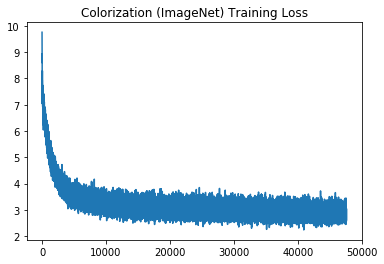

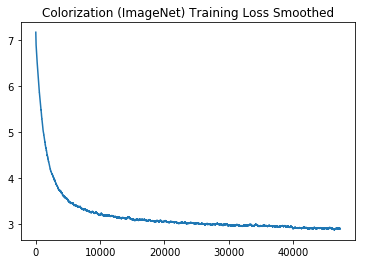

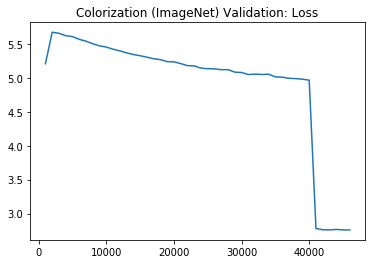

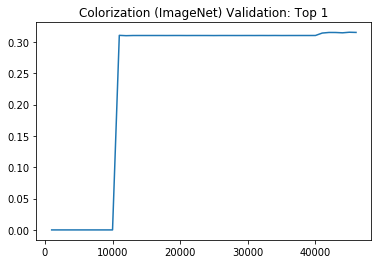

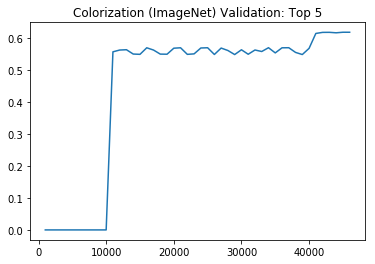

In [5]:
args = ['exp_reg', 'colorization', 'assignment2']
plt_reg_and_smoothed(get_losses(*args), 'Colorization (ImageNet) Training Loss')
plot_accuracies(get_imagenet_validation_data(*args), 'Colorization (ImageNet) Validation')

### Colorization (CIFAR trained) model

The training loss curve is similar to the ImageNet-trained model, but converges in fewer iterations due to the CIFAR-trained models smaller size. The validation curves exhibit the same error artifacts are previously described.

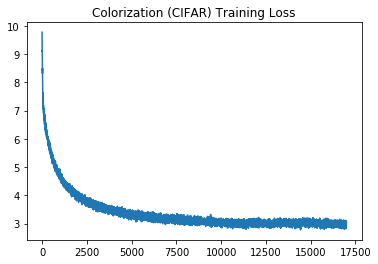

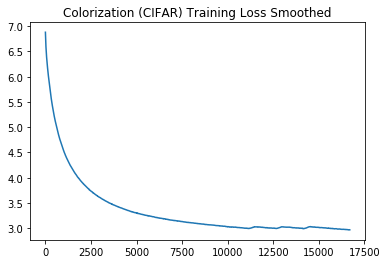

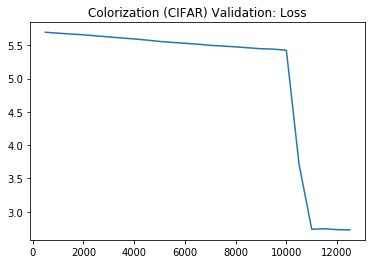

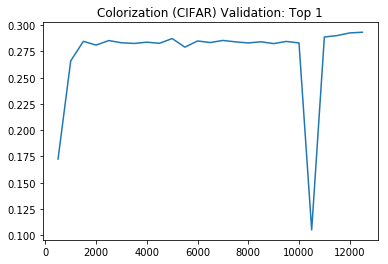

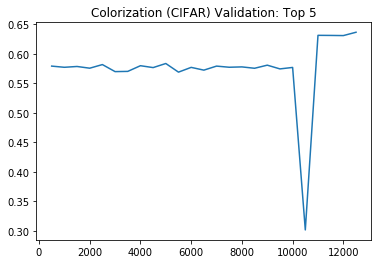

In [6]:
args = ['cifar1', 'colorization', 'assignment2']
plt_reg_and_smoothed(get_losses(*args), 'Colorization (CIFAR) Training Loss')
plot_accuracies(get_cifar_validation_data(*args), 'Colorization (CIFAR) Validation')

# Neural Analysis
The neural analysis results for this model are only run at one training step because the batch normalization issue was not discovered until the training loss had already flattened. Validation results from earlier timesteps are garbage because they exhibit the batch normalization issue.

The results tend to follow the same patterns. For the ImageNet trained model, layers 5-7 perform the best on generalization tasks while in the CIFAR trained model, layers 2-4 perform the best. This suggests that the smaller dimensions of the CIFAR model resulted in earlier abstraction representation. In addition, the performance of the CIFAR model is limited by the fact that input images were randomly cropped to 24x24. For both models, performance is noticeably degraded when using only the V6 examples.

## RDMs
### Colorization (ImageNet trained) model
The RDM correlation between the neural network and the IT features peaks in the middle of the network, around layers 5-7. Later layers in the network exhibit lower correlation, as they are likely more trained for the colorization task than a general feature representation. The block diagonal structures in the RDM are also the most visible in these layers. These structures become much less clear when only using the high variation examples, as is expected.

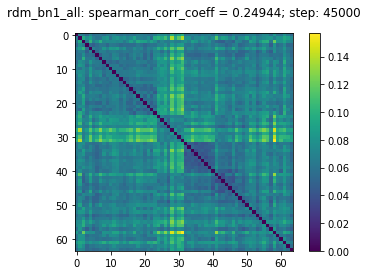

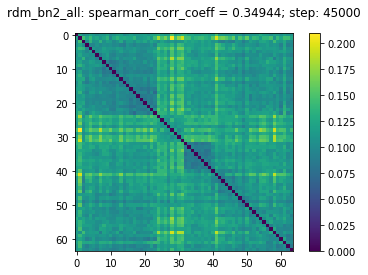

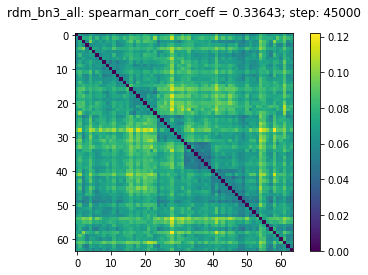

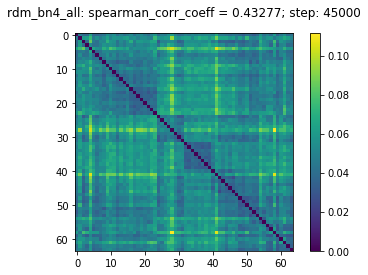

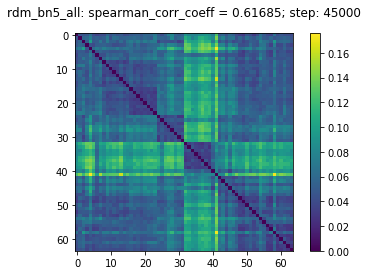

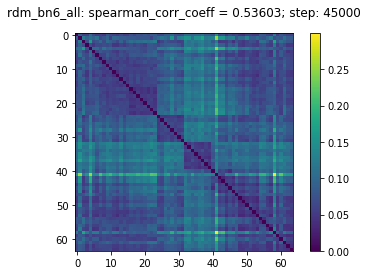

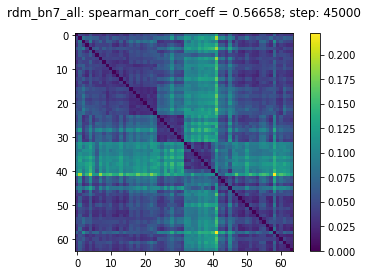

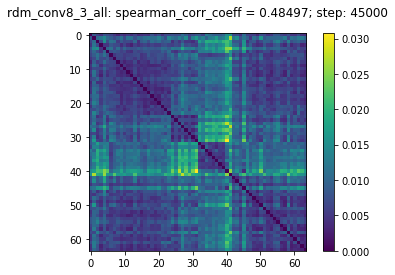

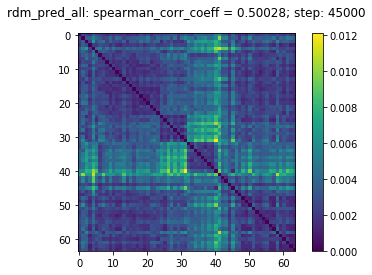

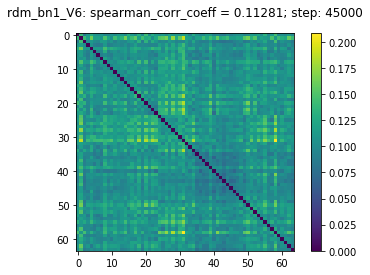

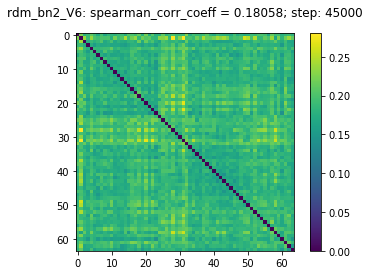

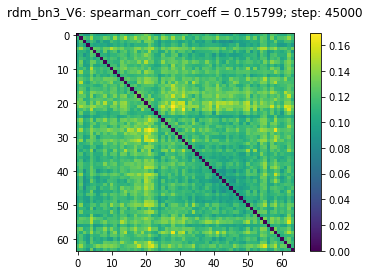

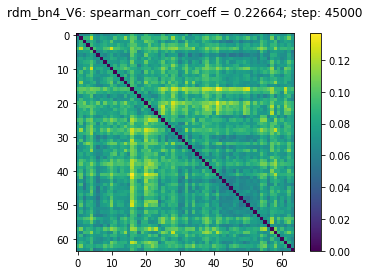

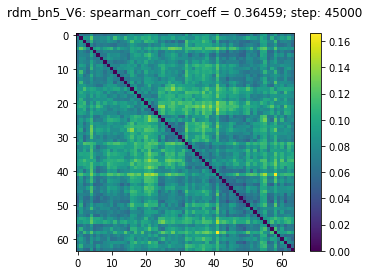

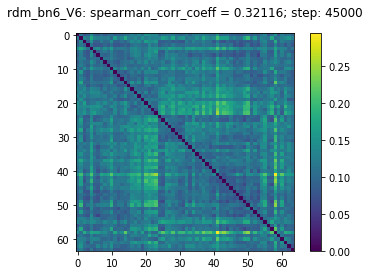

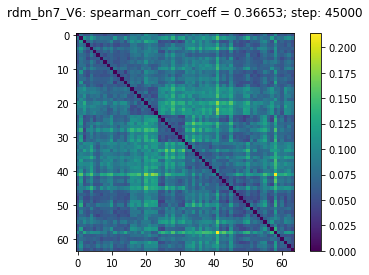

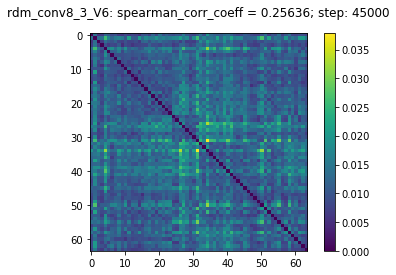

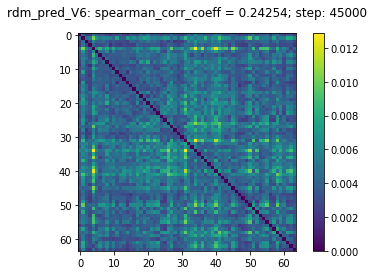

In [7]:
imagenet_step = 45000
exp_id = 'exp_reg_%s' % imagenet_step
collname = 'colorization'
dbname = 'assignment2'
target_layers = ['bn' + str(i) for i in range(1, 8)] + ['conv8_3', 'pred']
imagenet_data = get_neural_validation_data(exp_id, collname, dbname)[-1]['validation_results']['neural']
#print "Model: {0}, training index: {1}".format(collname, idx)
#print "rdms"
plot_rdms(imagenet_data, target_layers, imagenet_step, variation='all')
plot_rdms(imagenet_data, target_layers, imagenet_step, variation='V6')

### Colorization (CIFAR trained) model
In contrast to the ImageNet trained model, correlation peaks earlier in the network for the CIFAR model, around layers 2-4. These layers also exhibit the most structure in their RDMs.

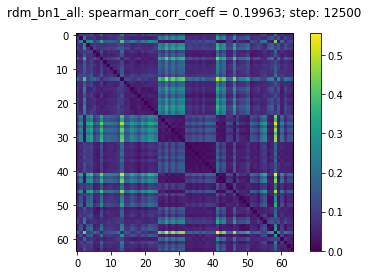

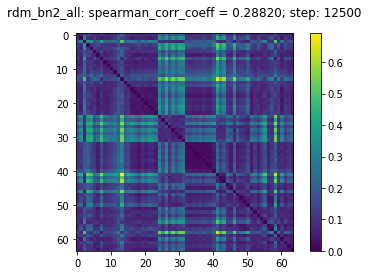

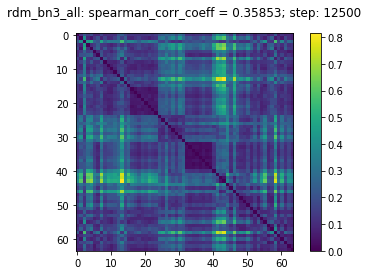

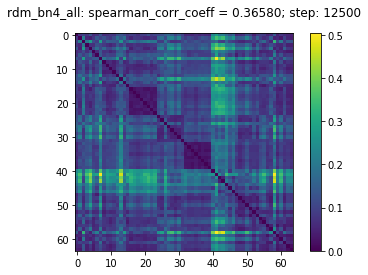

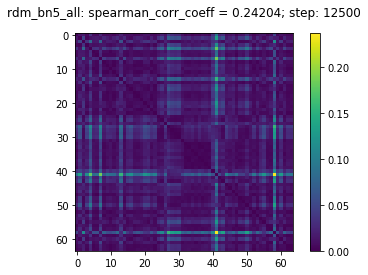

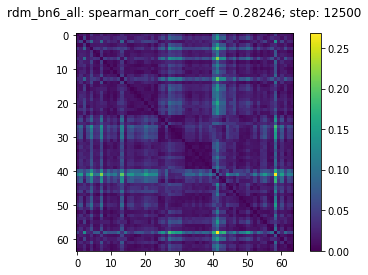

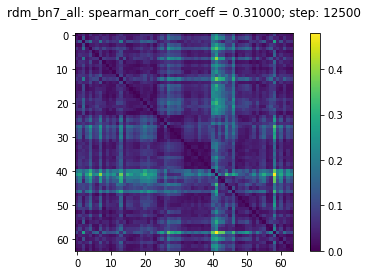

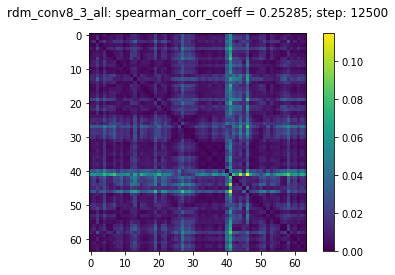

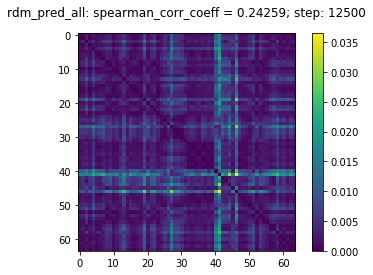

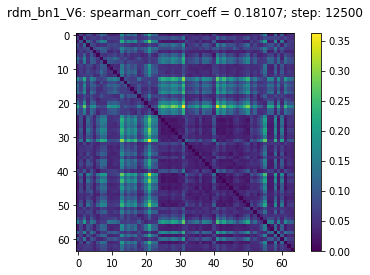

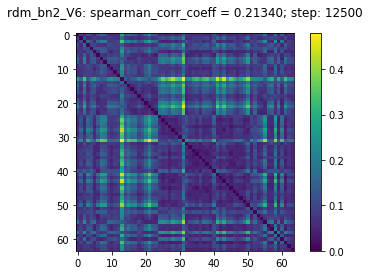

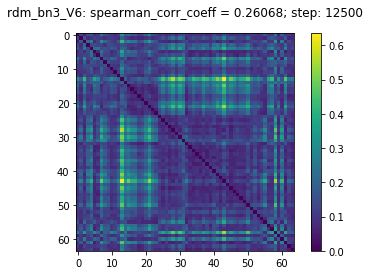

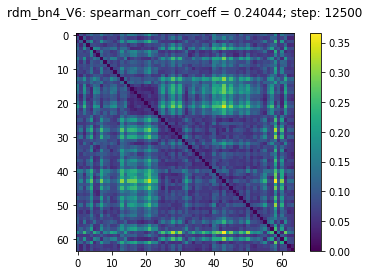

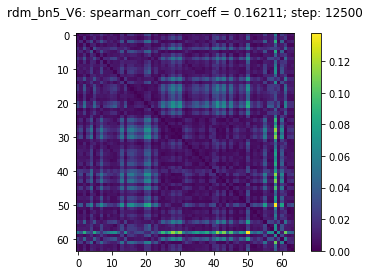

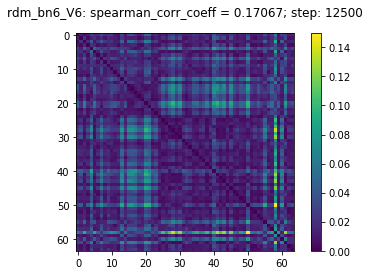

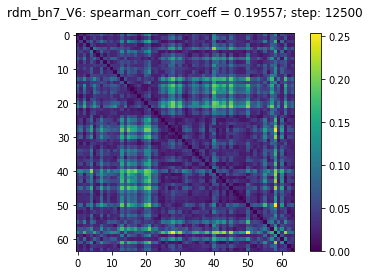

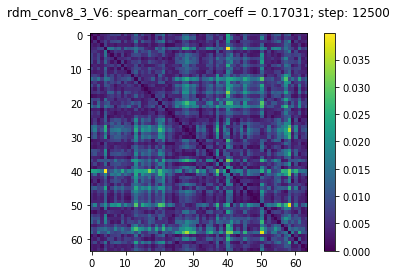

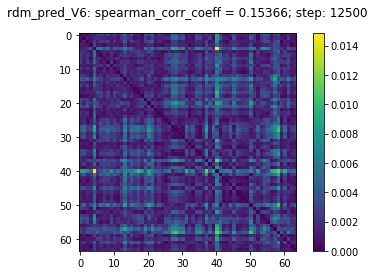

In [8]:
cifar_step = 12500
exp_id = 'cifar1_%s' % cifar_step
collname = 'colorization'
dbname = 'assignment2'
target_layers = ['bn' + str(i) for i in range(1, 8)] + ['conv8_3', 'pred']
cifar_data = get_neural_validation_data(exp_id, collname, dbname)[-1]['validation_results']['neural']
#print "Model: {0}, training index: {1}".format(collname, idx)
#print "rdms"
plot_rdms(cifar_data, target_layers, cifar_step, variation='all')
plot_rdms(cifar_data, target_layers, cifar_step, variation='V6')

## Categorization results
### Colorization (ImageNet trained) model
As before, the highest accuracy is achieved by layers 5-7 in the model, suggesting that these later layers generate feature representations useful for object identification that are then fed to the final layers to convert to colorization values. Results within the V6 subset are very poor, but still peak over layers 5-7.

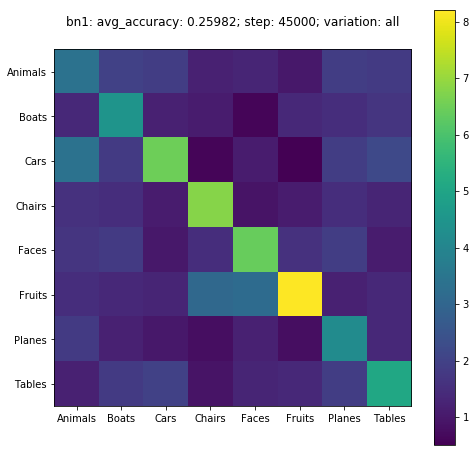

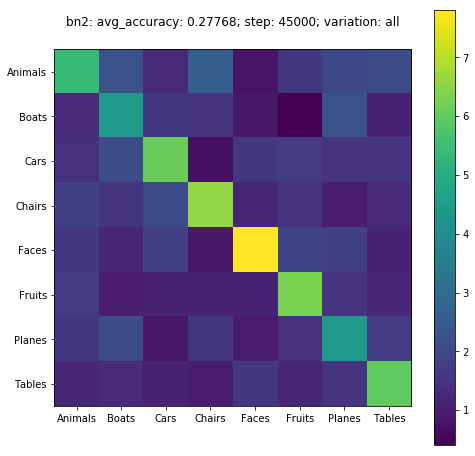

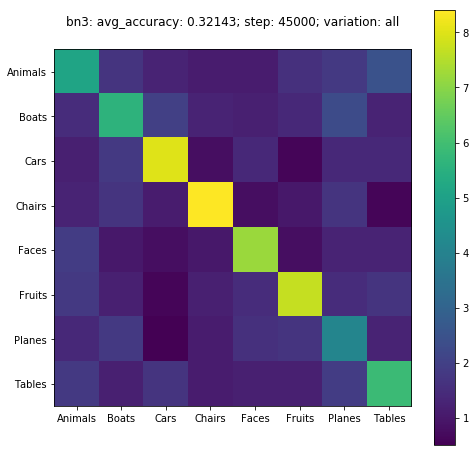

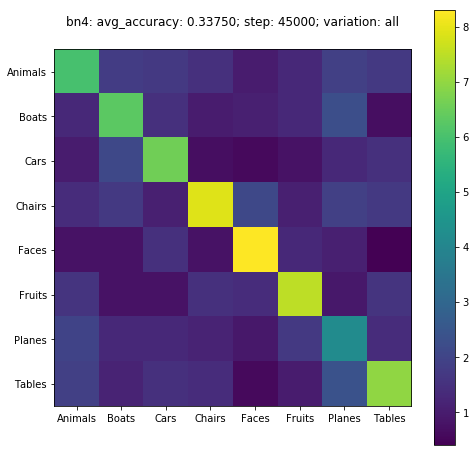

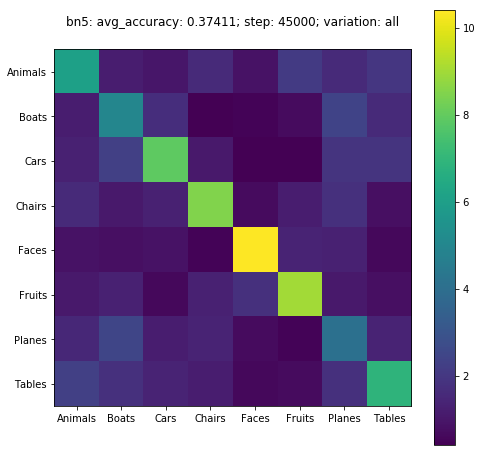

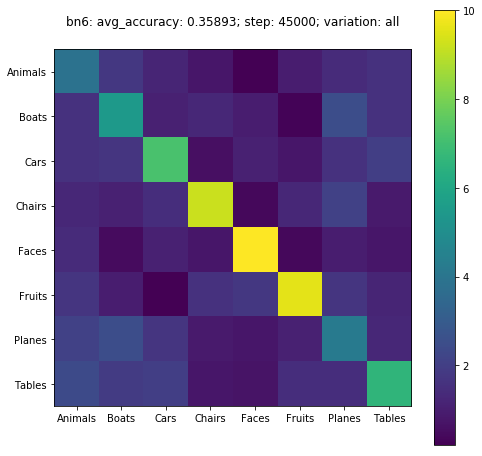

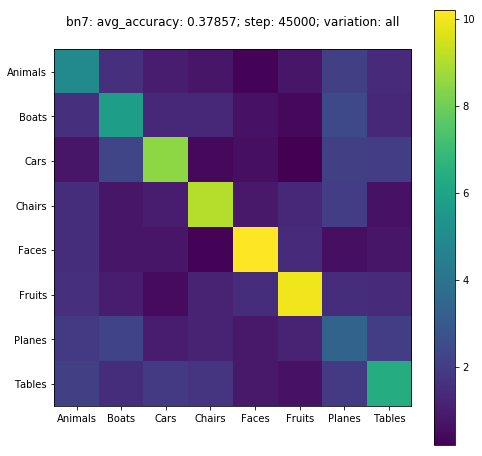

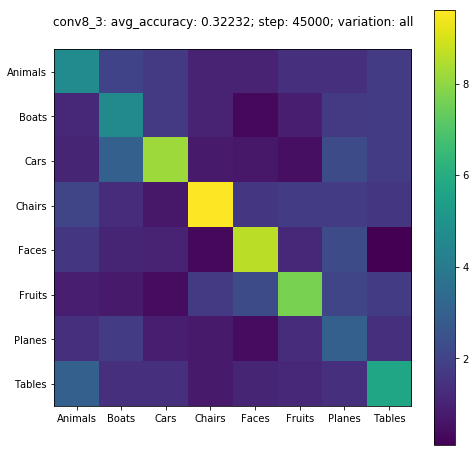

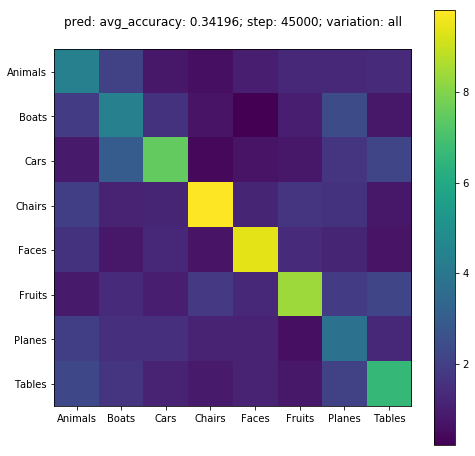

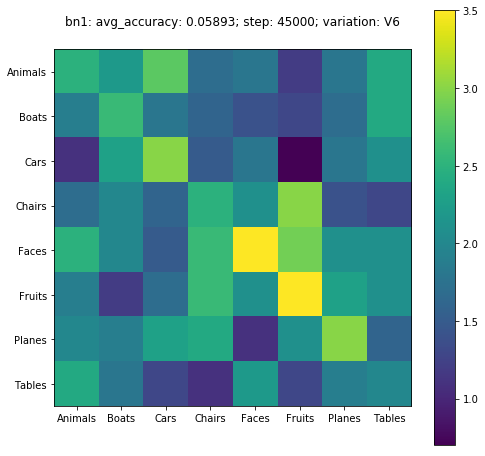

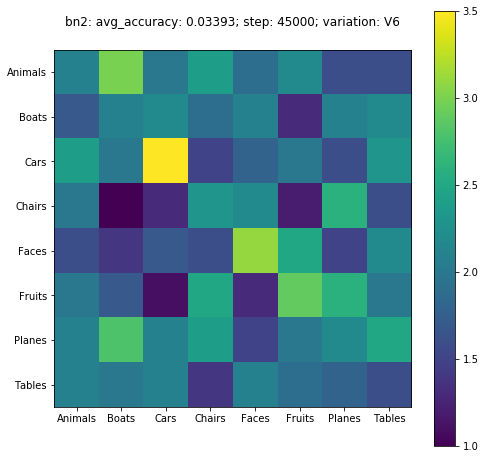

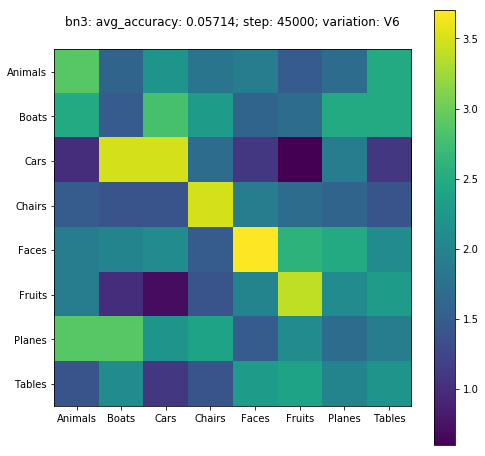

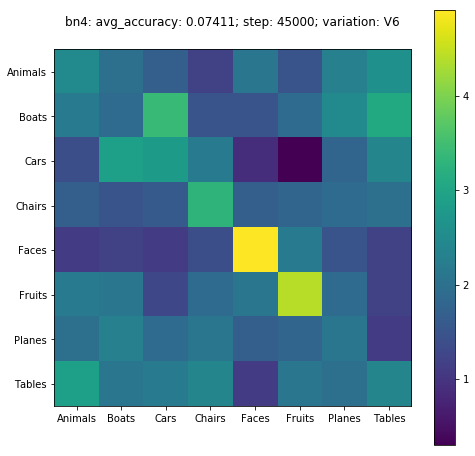

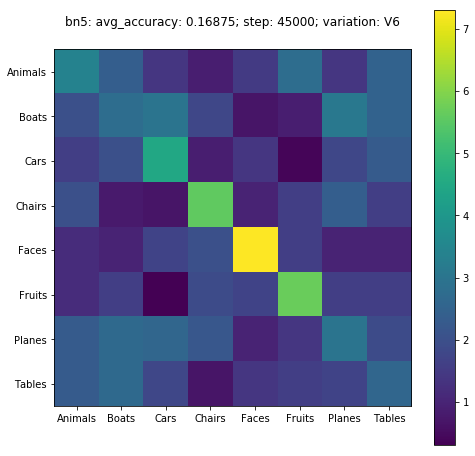

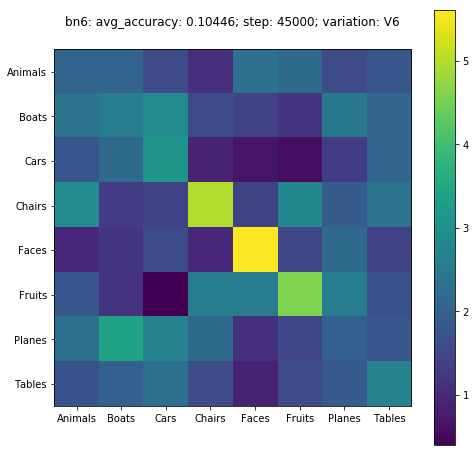

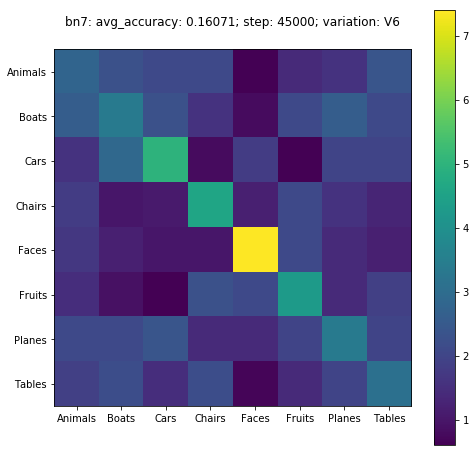

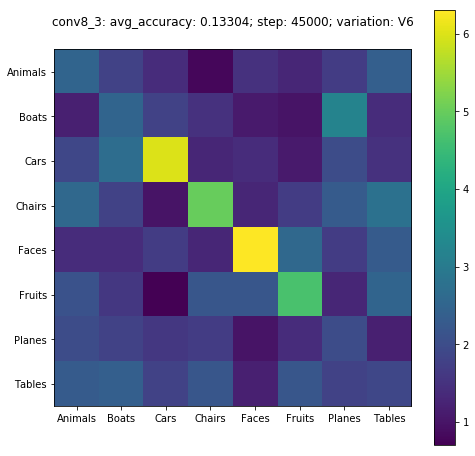

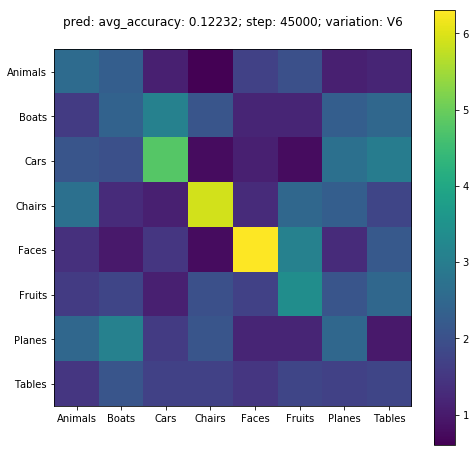

In [9]:
plot_categorization_results(imagenet_data, target_layers, imagenet_step, variation='all')
plot_categorization_results(imagenet_data, target_layers, imagenet_step, variation='V6')

### Colorization (CIFAR trained) model
As in the RDM analysis, this model's categorization performance peaks in layers 2-4, suggesting that these are the layers most strongly correlated to object representation while later layers are for colorization. It's interesting that these layers are earlier in the CIFAR model than the ImageNet model.

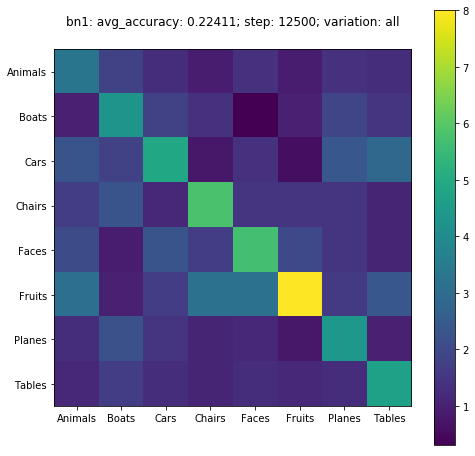

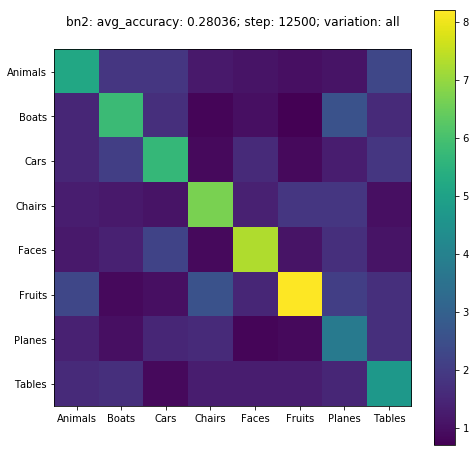

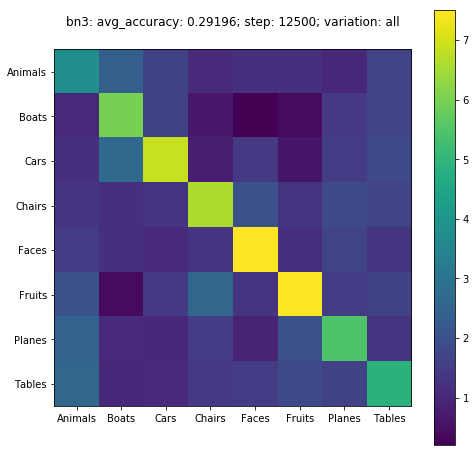

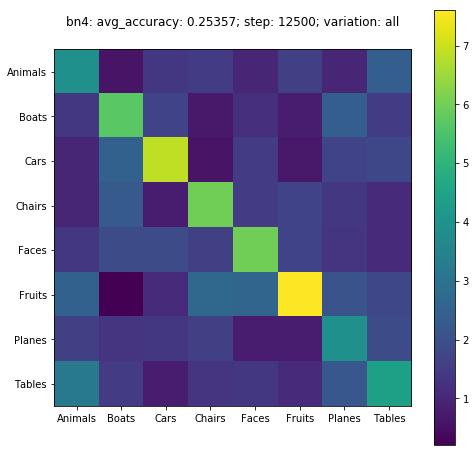

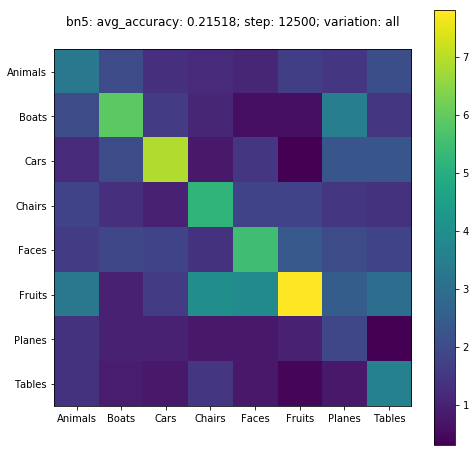

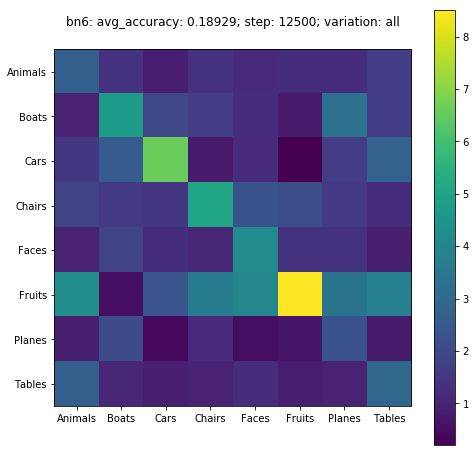

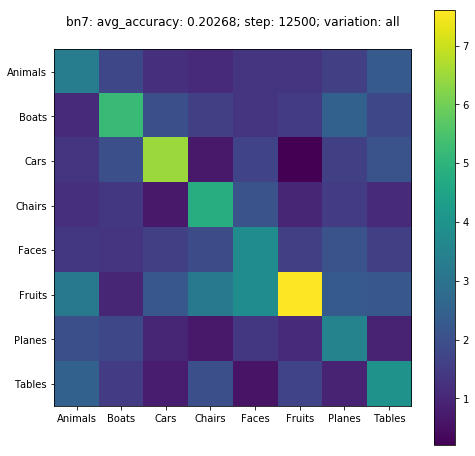

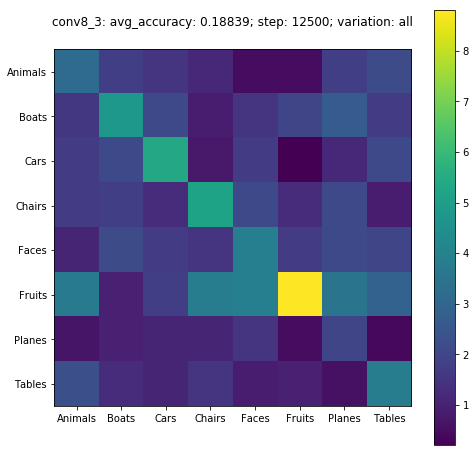

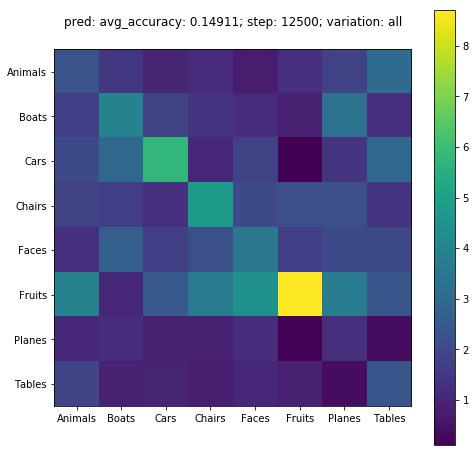

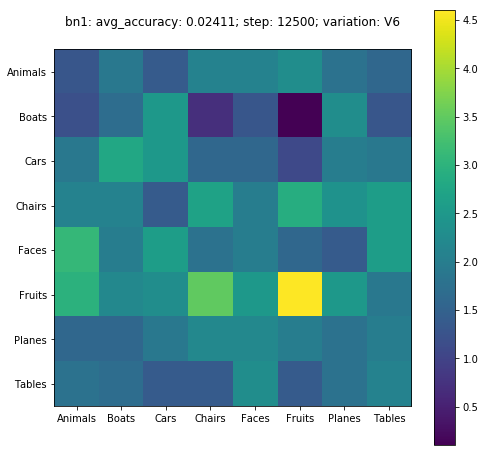

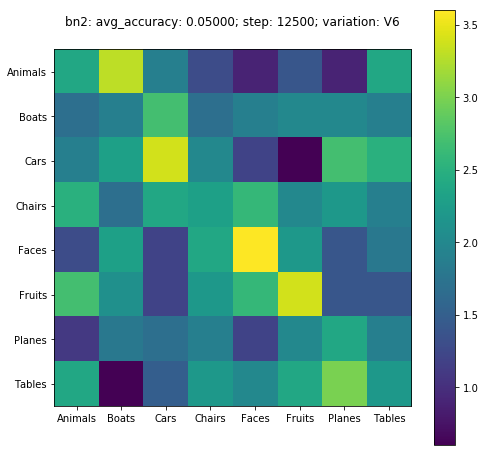

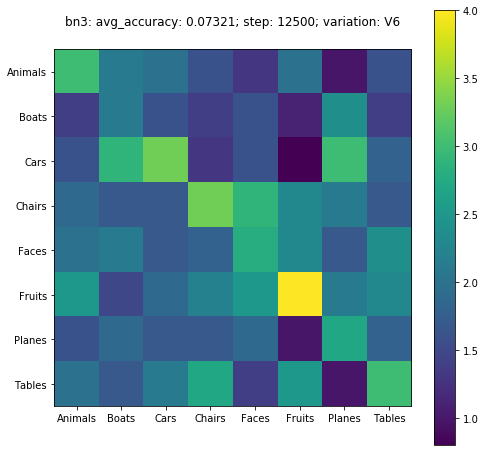

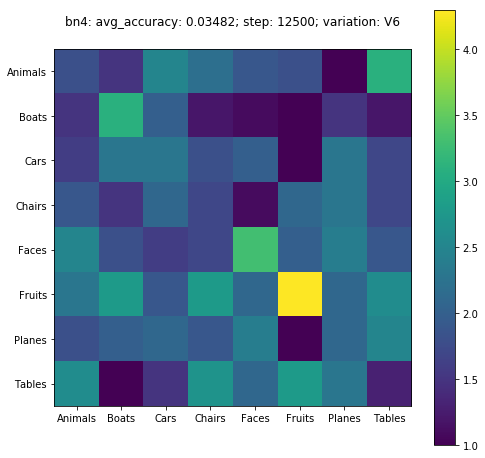

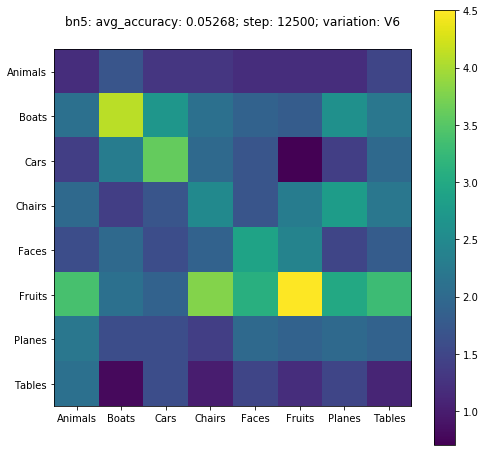

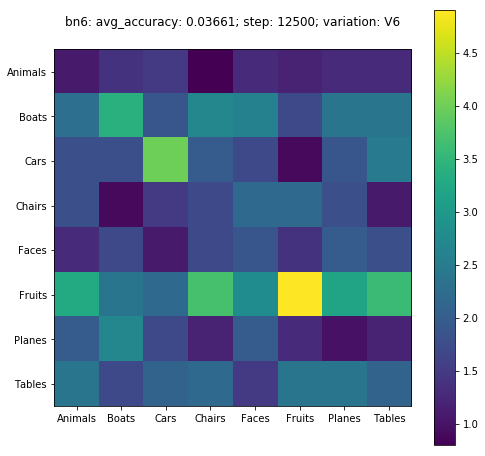

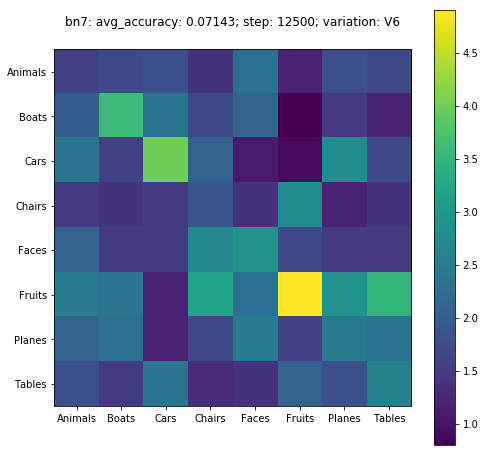

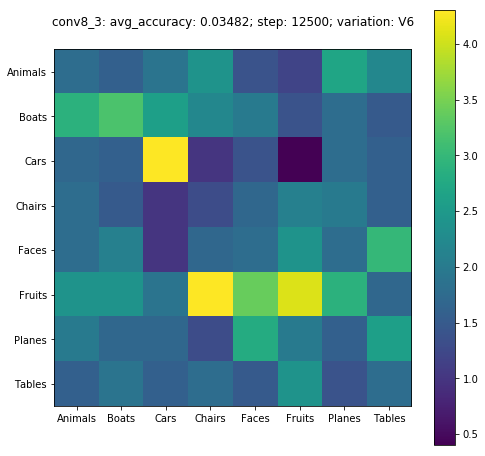

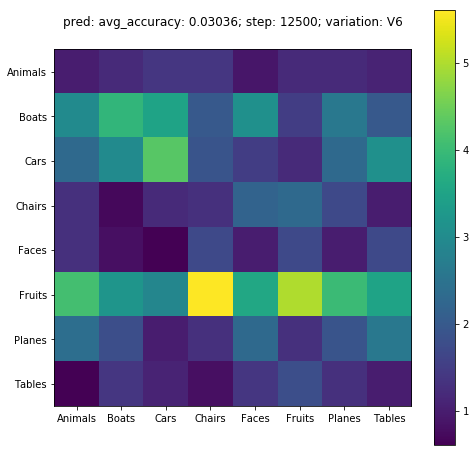

In [10]:
plot_categorization_results(cifar_data, target_layers, cifar_step, variation='all')
plot_categorization_results(cifar_data, target_layers, cifar_step, variation='V6')

## Within-category identification
### Colorization (ImageNet trained) model
Same as before, peak performance in layers 5-7. Interestingly, the final logit output layer also performs well, perhaps because the fruits are differentiable by a color feature presentation.

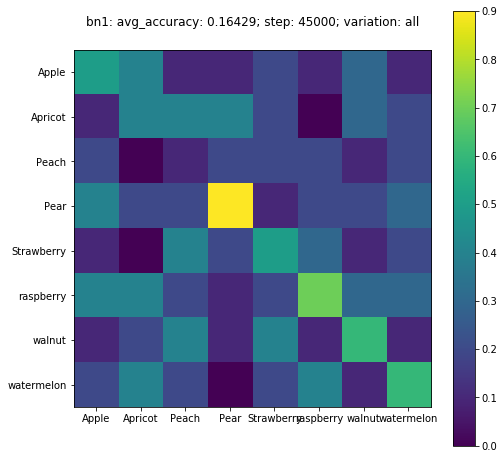

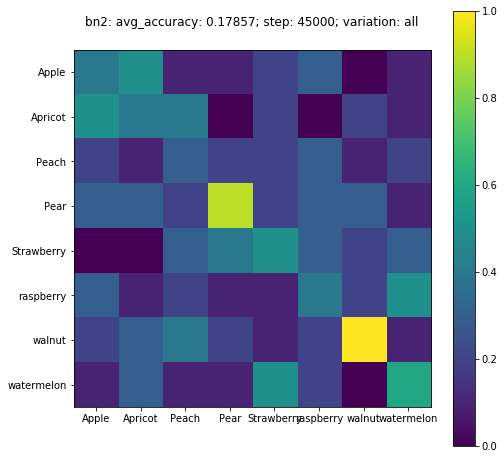

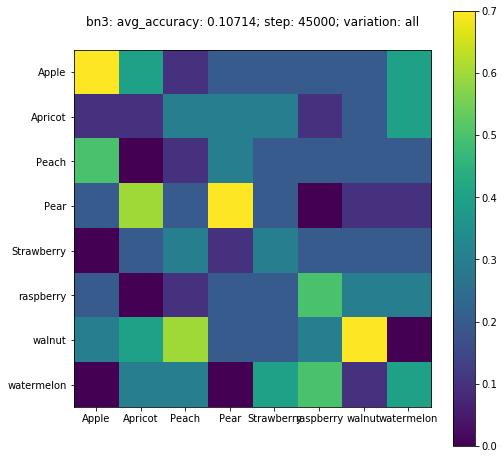

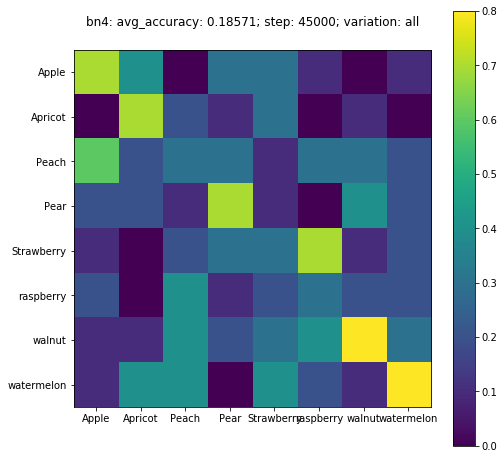

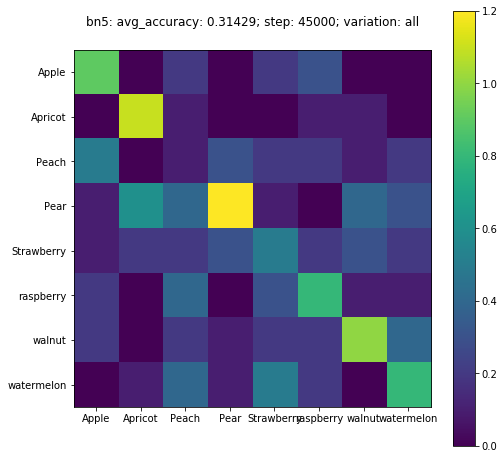

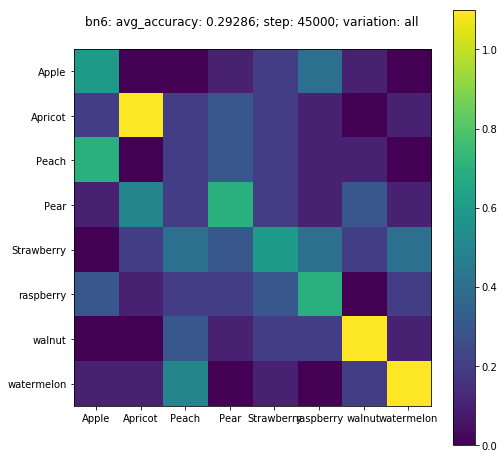

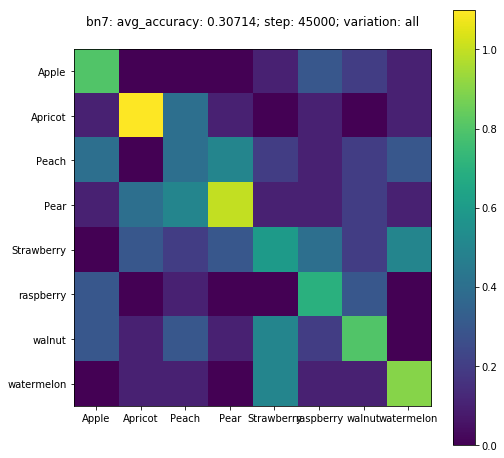

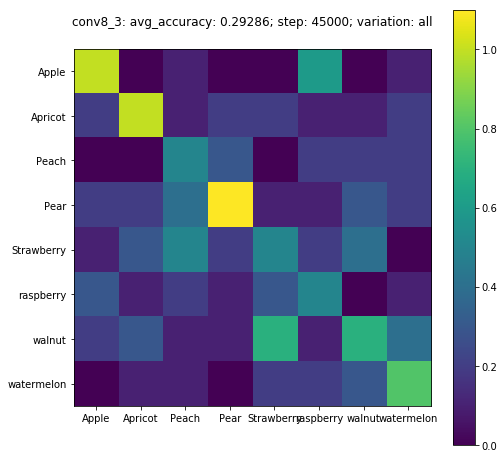

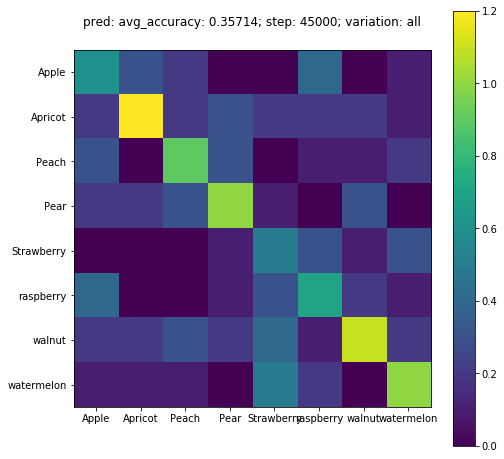

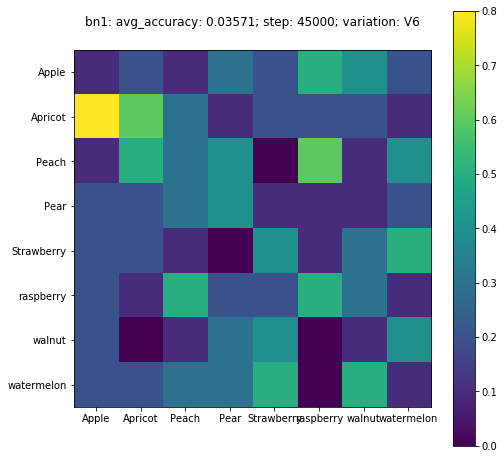

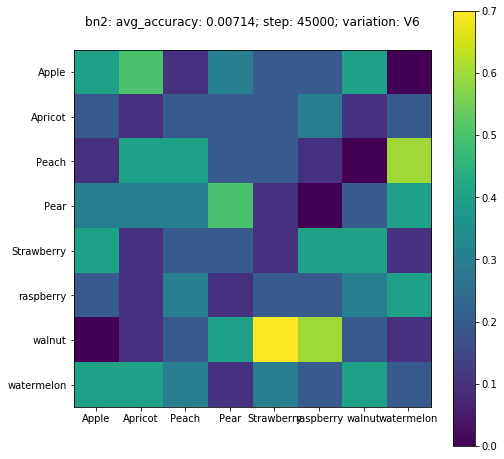

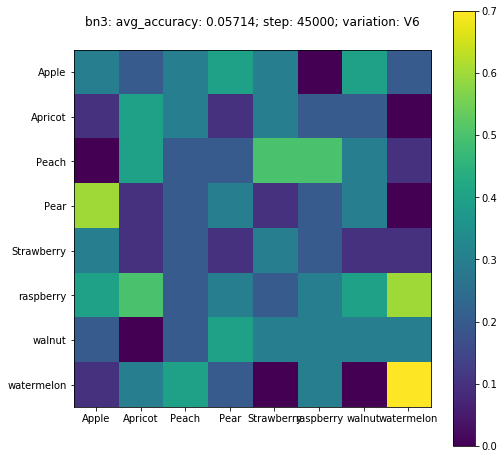

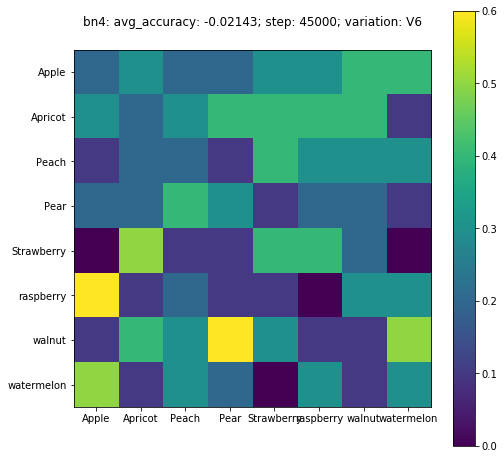

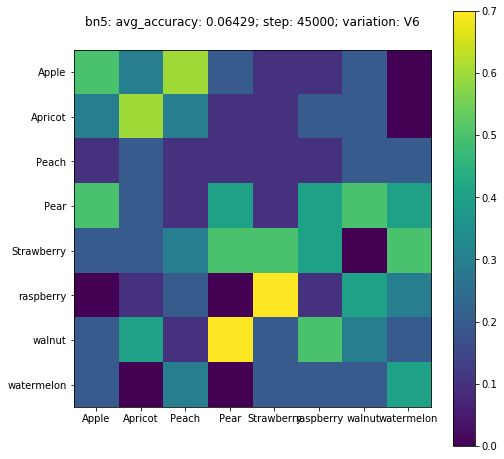

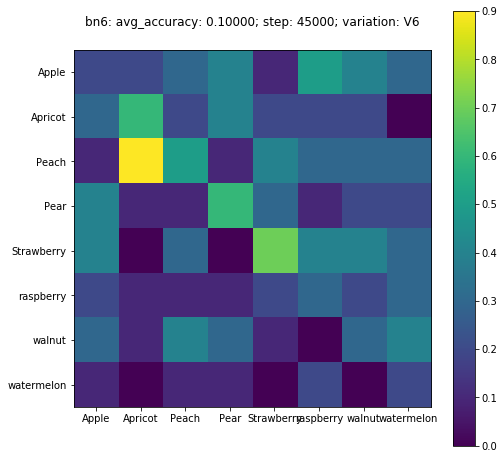

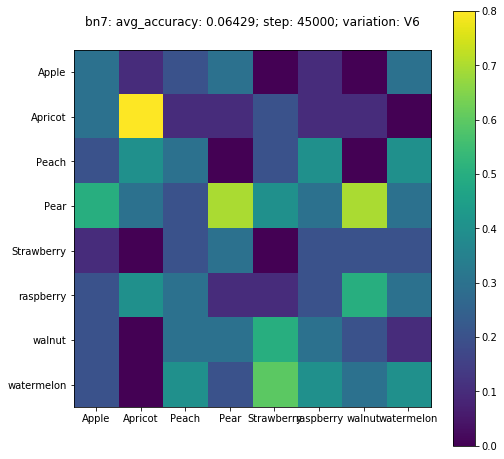

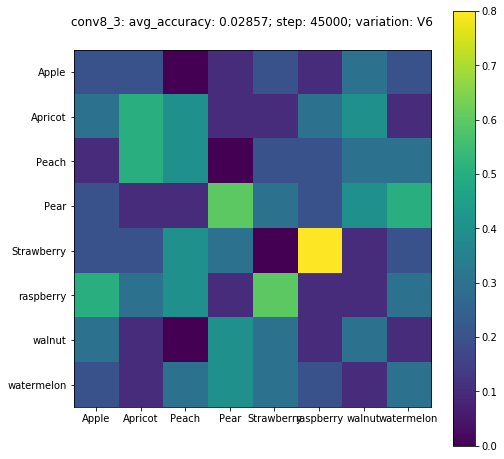

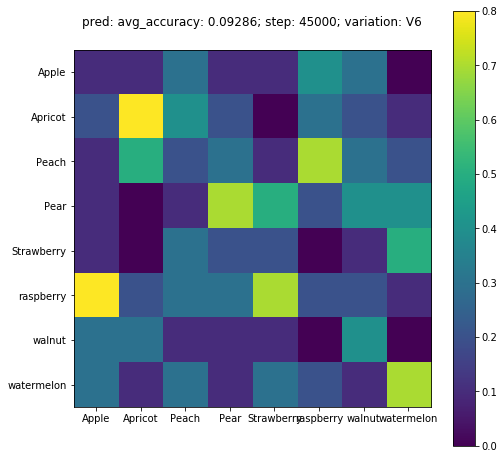

In [11]:
plot_identification_results(imagenet_data, target_layers, imagenet_step, variation='all')
plot_identification_results(imagenet_data, target_layers, imagenet_step, variation='V6')

### Colorization (CIFAR trained) model
Surprisingly, the CIFAR trained model performs better than the ImageNet trained model on the full training set from layer 3 onwards. On the high variation subset, it performs noticeably worse.

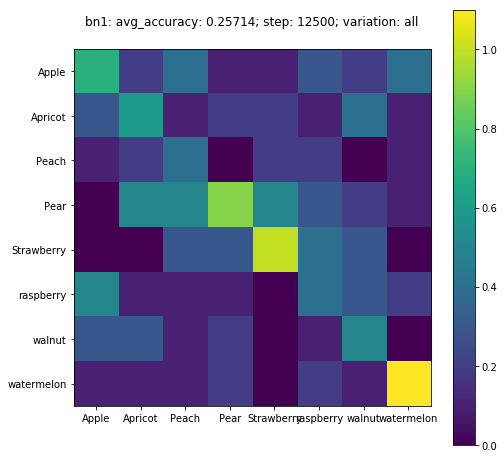

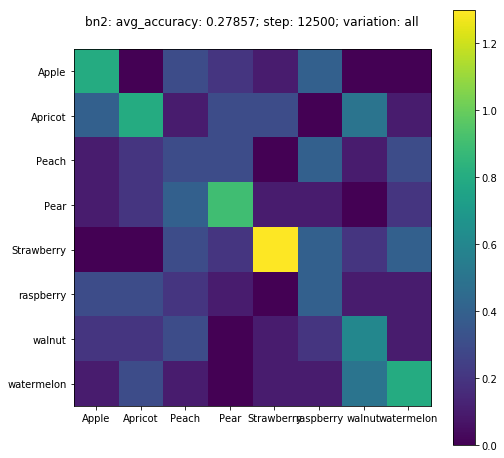

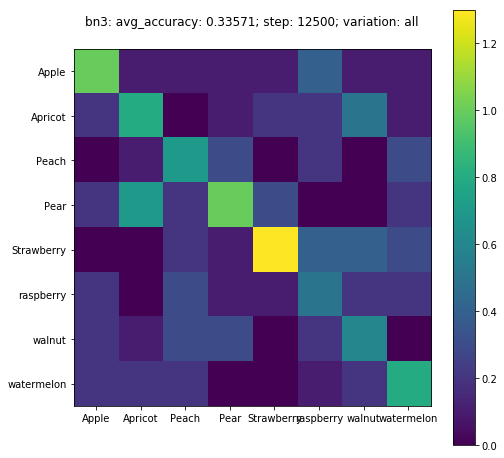

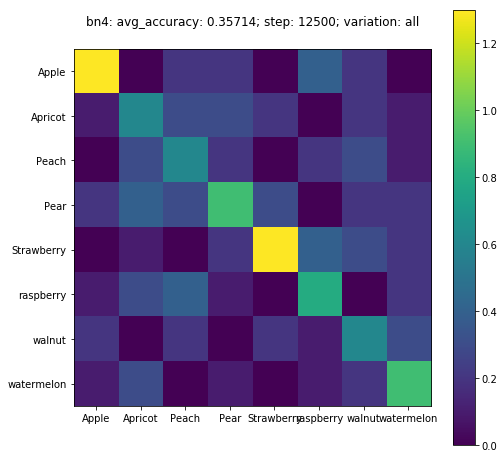

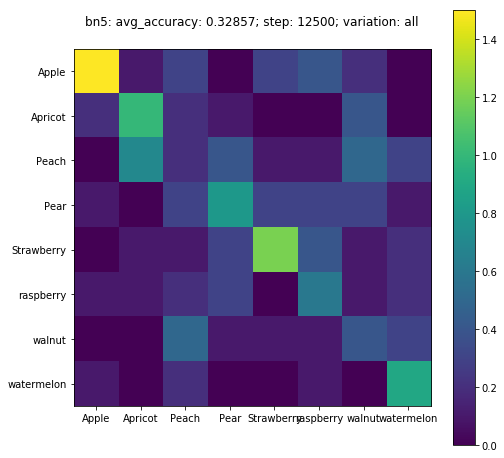

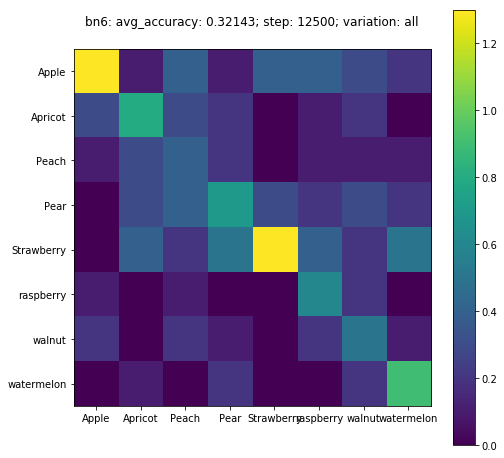

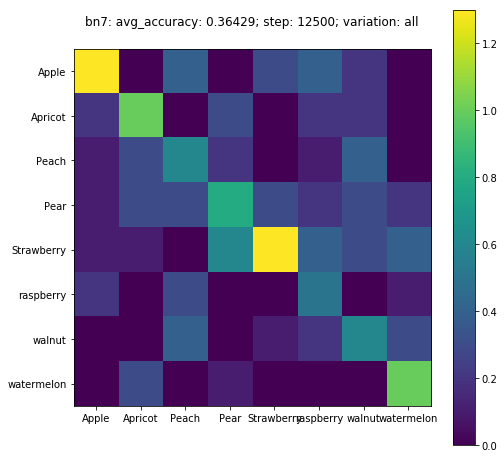

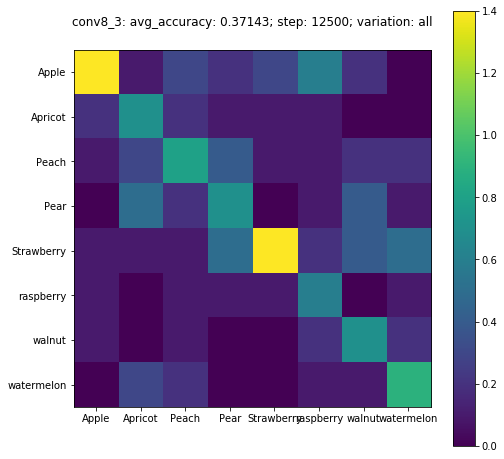

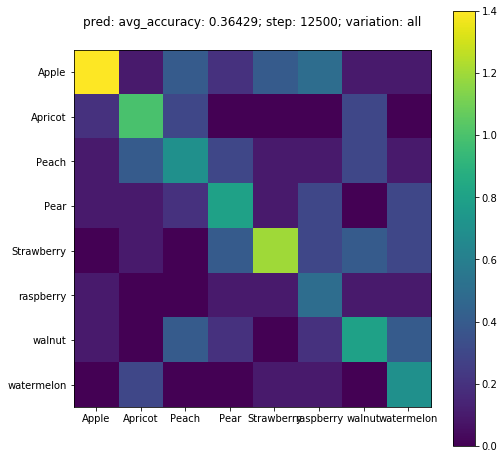

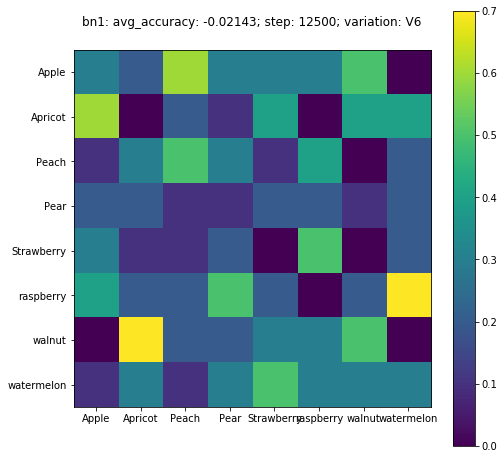

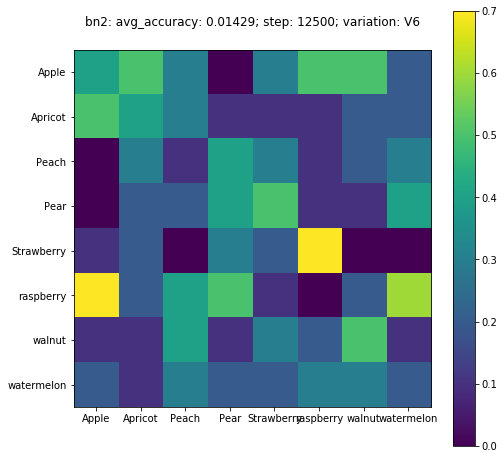

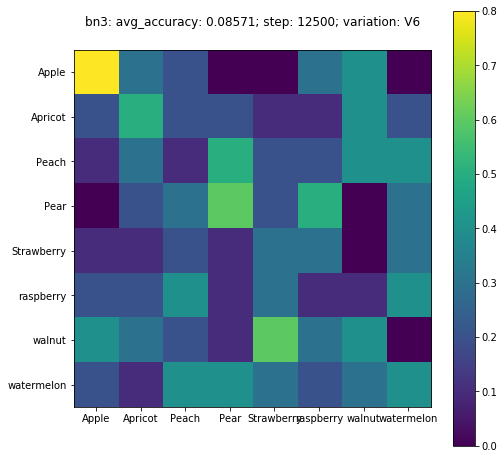

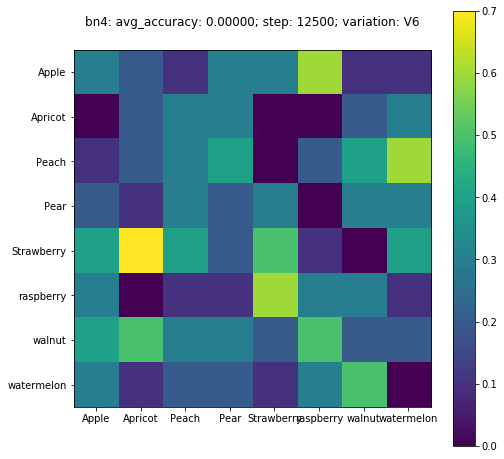

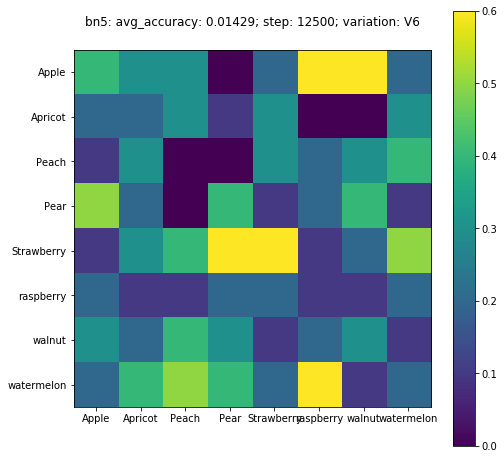

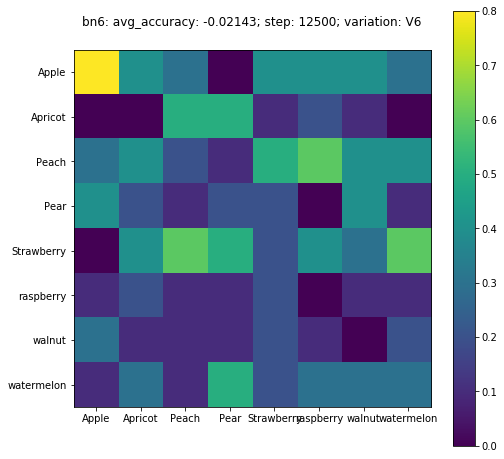

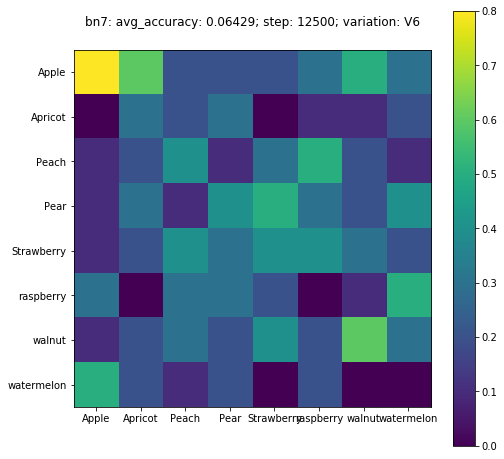

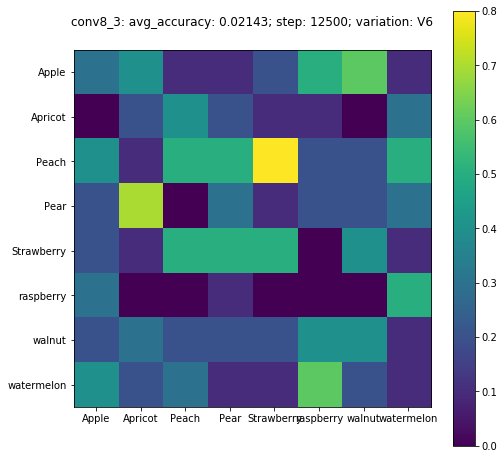

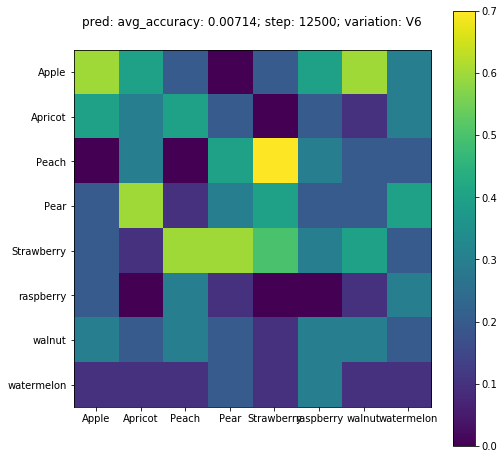

In [12]:
plot_identification_results(cifar_data, target_layers, cifar_step, variation='all')
plot_identification_results(cifar_data, target_layers, cifar_step, variation='V6')

## Continuous (ty) estimation
### Colorization (ImageNet trained) model
Here, performance peaks at layer 5, with the later layers again exhibiting better performance than the early layers.

In [13]:
plot_estimation_results(imagenet_data, target_layers, imagenet_step, variation='all')
plot_estimation_results(imagenet_data, target_layers, imagenet_step, variation='V6')

Layer: bn1, variation: all, step: 45000, value: -0.015180000051
Layer: bn2, variation: all, step: 45000, value: -0.0435776227603
Layer: bn3, variation: all, step: 45000, value: 0.194402374242
Layer: bn4, variation: all, step: 45000, value: 0.2282411559
Layer: bn5, variation: all, step: 45000, value: 0.377150644457
Layer: bn6, variation: all, step: 45000, value: 0.318436796304
Layer: bn7, variation: all, step: 45000, value: 0.312579617914
Layer: conv8_3, variation: all, step: 45000, value: 0.261794754849
Layer: pred, variation: all, step: 45000, value: 0.223533336053
Layer: bn1, variation: V6, step: 45000, value: -0.275045868808
Layer: bn2, variation: V6, step: 45000, value: -0.213525994806
Layer: bn3, variation: V6, step: 45000, value: 0.0921038587583
Layer: bn4, variation: V6, step: 45000, value: 0.18476438664
Layer: bn5, variation: V6, step: 45000, value: 0.397430842266
Layer: bn6, variation: V6, step: 45000, value: 0.32357291366
Layer: bn7, variation: V6, step: 45000, value: 0.23648

### Colorization (CIFAR trained) model
The CIFAR model performs terribly at this task, which is not surprising considering that its input is generating by randomly cropping the examples down to 24x24. This essentially removes any ability to spatially place the object in the rest of the image.

In [14]:
plot_estimation_results(cifar_data, target_layers, cifar_step, variation='all')
plot_estimation_results(cifar_data, target_layers, cifar_step, variation='V6')

Layer: bn1, variation: all, step: 12500, value: -0.130144096422
Layer: bn2, variation: all, step: 12500, value: -0.148856632716
Layer: bn3, variation: all, step: 12500, value: -0.135749797034
Layer: bn4, variation: all, step: 12500, value: 0.00223220596899
Layer: bn5, variation: all, step: 12500, value: 0.00456967755681
Layer: bn6, variation: all, step: 12500, value: 0.00783905780769
Layer: bn7, variation: all, step: 12500, value: -0.0227386098156
Layer: conv8_3, variation: all, step: 12500, value: -0.00792467894336
Layer: pred, variation: all, step: 12500, value: 0.00540736426295
Layer: bn1, variation: V6, step: 12500, value: -0.389765697888
Layer: bn2, variation: V6, step: 12500, value: -0.577652286629
Layer: bn3, variation: V6, step: 12500, value: -0.497929157518
Layer: bn4, variation: V6, step: 12500, value: -0.0247356499335
Layer: bn5, variation: V6, step: 12500, value: 0.00754004884777
Layer: bn6, variation: V6, step: 12500, value: -0.00398202316541
Layer: bn7, variation: V6, ste

## Regression on IT neurons
Same findings as previously analyses here. The ImageNet model peaks in layers 5-7, the CIFAR model peaks in layers 2-4.

### Colorization (ImageNet trained) model

In [15]:
plot_regression_results(imagenet_data, target_layers, imagenet_step)

Layer: bn1, step: 45000, value: 0.110780630233
Layer: bn2, step: 45000, value: 0.116735511309
Layer: bn3, step: 45000, value: 0.200514083404
Layer: bn4, step: 45000, value: 0.223741577864
Layer: bn5, step: 45000, value: 0.328142593529
Layer: bn6, step: 45000, value: 0.251372600547
Layer: bn7, step: 45000, value: 0.297237146705
Layer: conv8_3, step: 45000, value: 0.224146894512
Layer: pred, step: 45000, value: 0.194271713695


### Colorization (CIFAR trained) model

In [16]:
plot_regression_results(cifar_data, target_layers, cifar_step)

Layer: bn1, step: 12500, value: 0.094043370805
Layer: bn2, step: 12500, value: 0.143663551853
Layer: bn3, step: 12500, value: 0.174256925586
Layer: bn4, step: 12500, value: 0.159136308871
Layer: bn5, step: 12500, value: 0.111122176218
Layer: bn6, step: 12500, value: 0.0923167578221
Layer: bn7, step: 12500, value: 0.1026751888
Layer: conv8_3, step: 12500, value: 0.105447937013
Layer: pred, step: 12500, value: 0.10020180204


## Conv-1 kernels
This model's conv-1 kernels are all 3x3, so there actually isn't much structure to be seen here.
### Colorization (ImageNet trained) model

Iteration step: 45000
(3, 3, 1, 64)


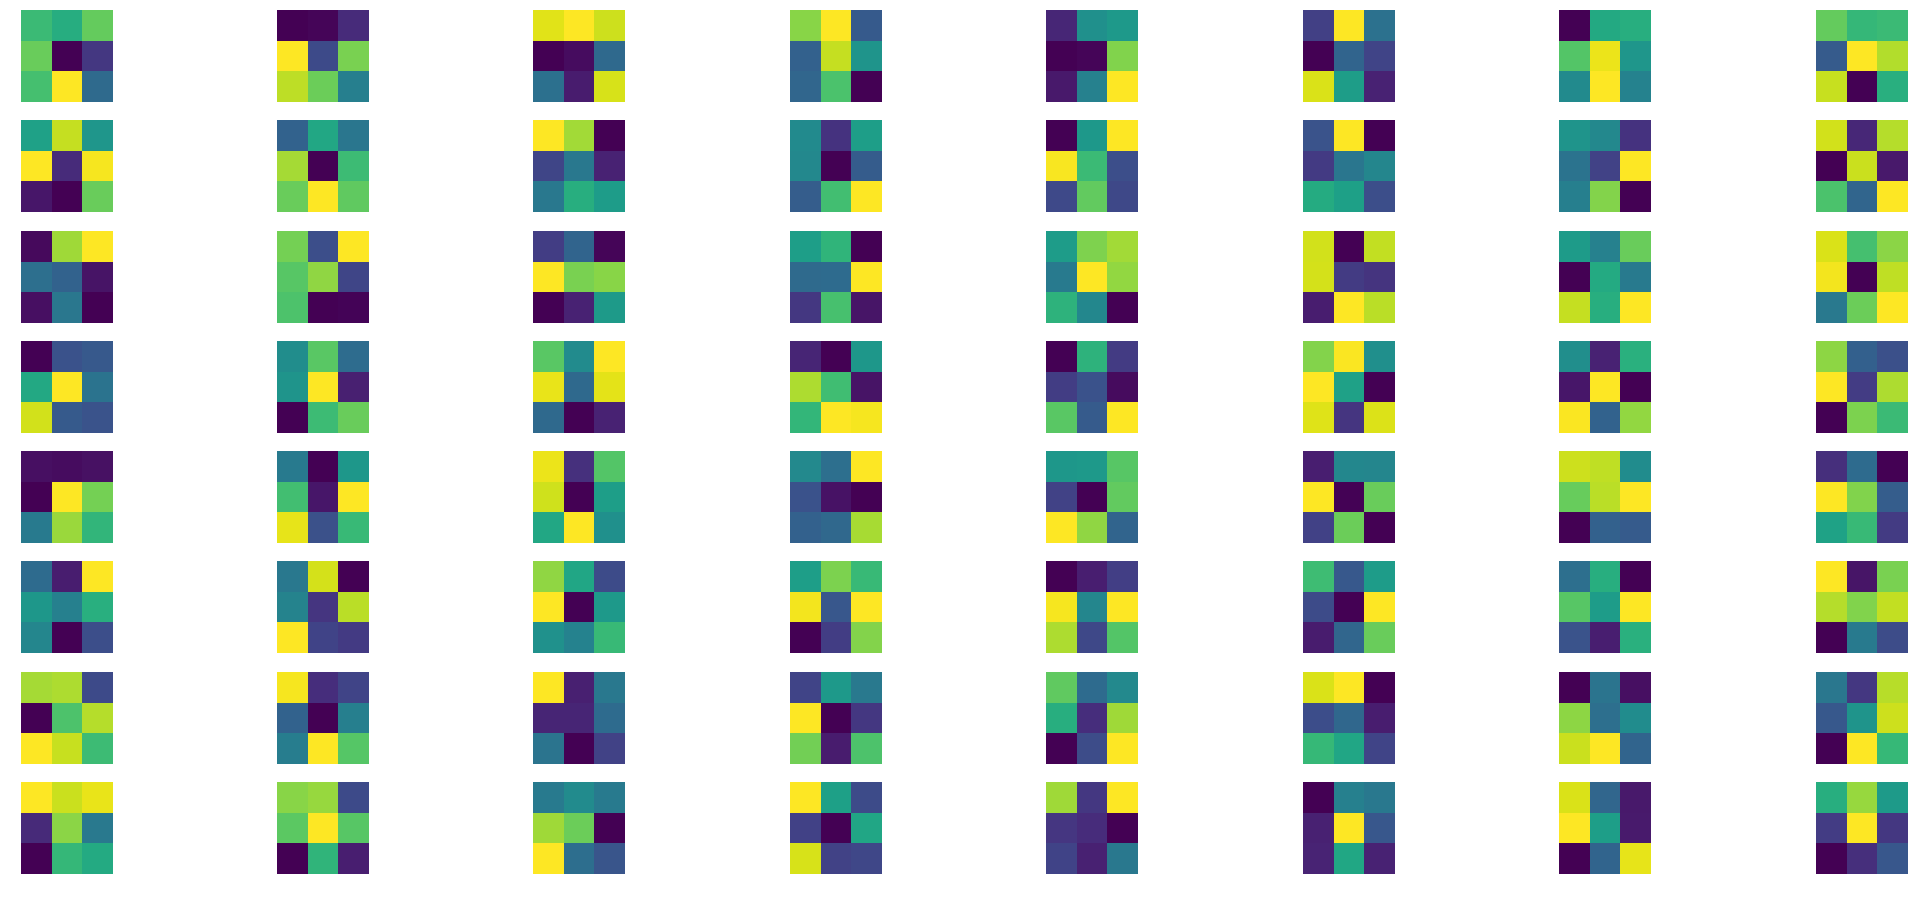

In [17]:
plot_conv1_kernels(imagenet_data, imagenet_step)

### Colorization (CIFAR trained) model

Iteration step: 12500
(3, 3, 1, 64)


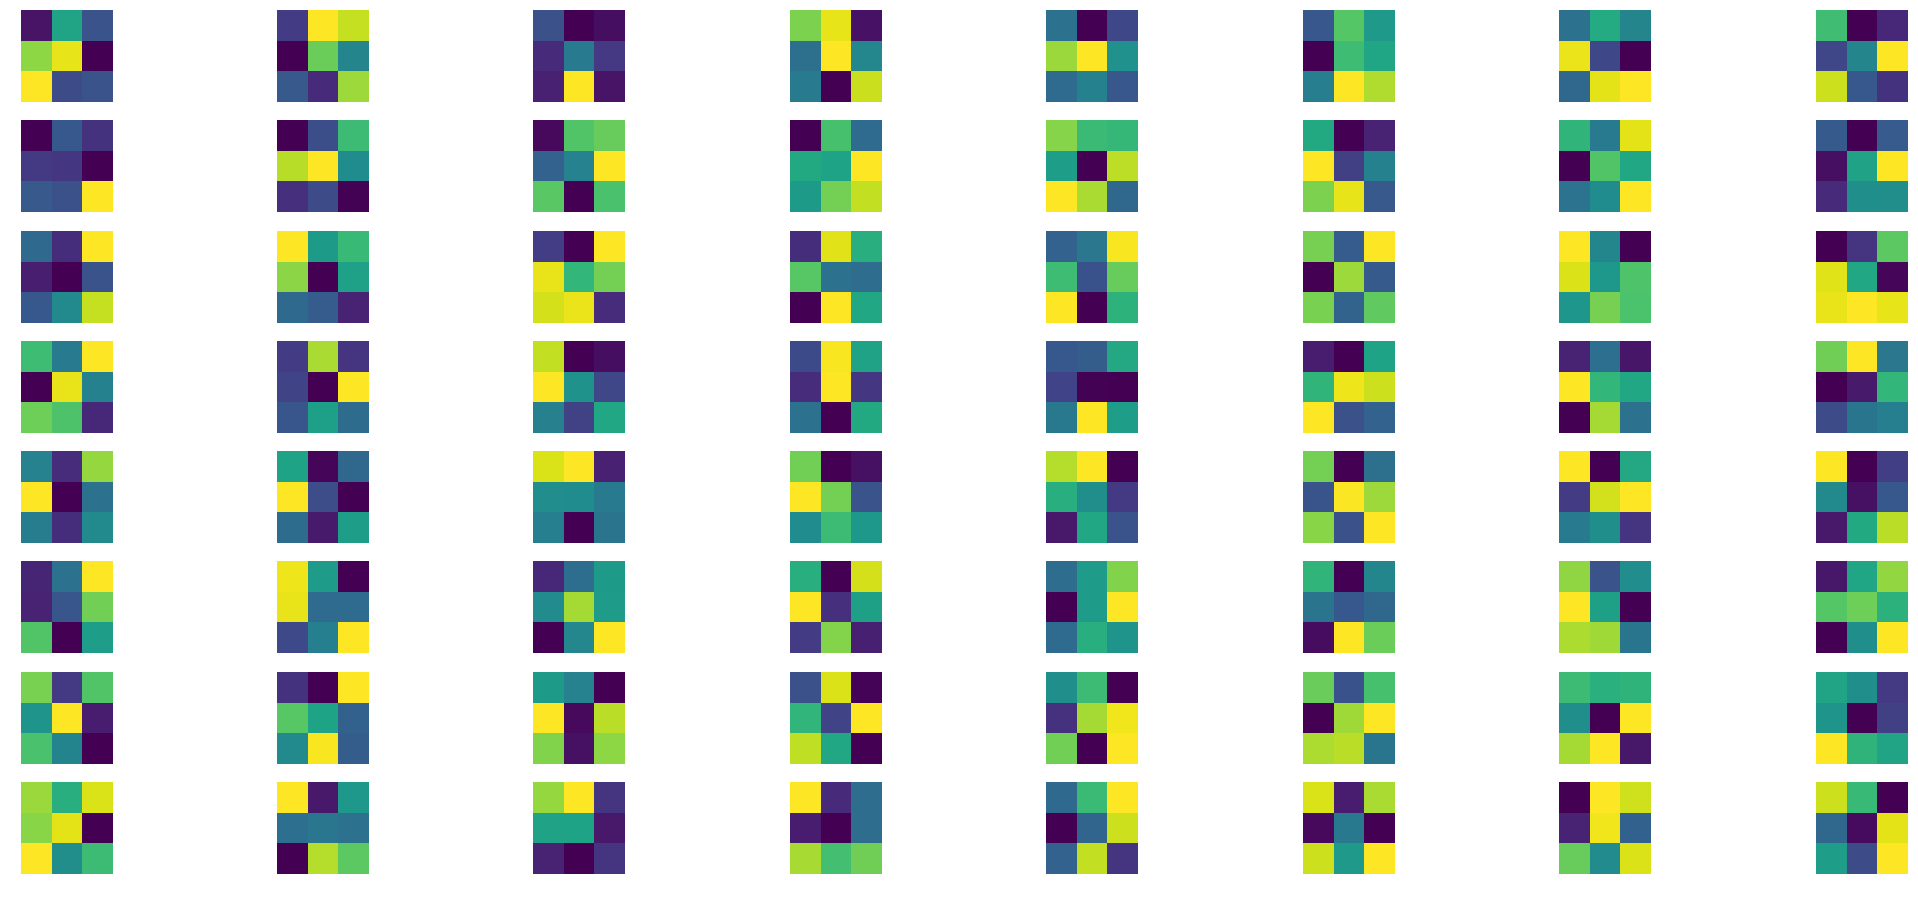

In [18]:
plot_conv1_kernels(cifar_data, cifar_step)

## ImageNet classification
ImageNet classification performance is evaluated by training a linear SVM on a subset of the ImageNet validation set considering of 100 labels instead of 1000 labels.

Again, the ImageNet model's performance peaks in the later layers, the CIFAR model's performance peaks in the earlier layers. The ImageNet model also outperform the CIFAR model, likely because of the difference in input dimensions (224x224 vs 24x24) which are generated by random cropping.
### Colorization (ImageNet trained) model

In [19]:
imagenet_step = 45000
exp_id = 'exp_reg_%s' % imagenet_step
collname = 'colorization'
dbname = 'assignment2'
target_layers = ['bn' + str(i) for i in range(1, 8)] + ['conv8_3', 'pred']
imagenet_data = get_classification_validation_data(exp_id, collname, dbname)[-1]['validation_results']['imagenet']
plot_imagenet_results(imagenet_data, target_layers, imagenet_step)

bn1: avg_accuracy: 0.10303; step: 45000
bn2: avg_accuracy: 0.10101; step: 45000
bn3: avg_accuracy: 0.13333; step: 45000
bn4: avg_accuracy: 0.15152; step: 45000
bn5: avg_accuracy: 0.19596; step: 45000
bn6: avg_accuracy: 0.19327; step: 45000
bn7: avg_accuracy: 0.17912; step: 45000
conv8_3: avg_accuracy: 0.17778; step: 45000
pred: avg_accuracy: 0.15556; step: 45000


### Colorization (CIFAR trained) model

In [20]:
cifar_step = 12500
exp_id = 'cifar1_%s' % cifar_step
collname = 'colorization'
dbname = 'assignment2'
target_layers = ['bn' + str(i) for i in range(1, 8)] + ['conv8_3', 'pred']
cifar_data = get_classification_validation_data(exp_id, collname, dbname)[-1]['validation_results']['imagenet']
plot_imagenet_results(cifar_data, target_layers, cifar_step)

bn1: avg_accuracy: 0.03771; step: 12500
bn2: avg_accuracy: 0.03973; step: 12500
bn3: avg_accuracy: 0.04781; step: 12500
bn4: avg_accuracy: 0.04983; step: 12500
bn5: avg_accuracy: 0.04512; step: 12500
bn6: avg_accuracy: 0.02761; step: 12500
bn7: avg_accuracy: 0.03502; step: 12500
conv8_3: avg_accuracy: 0.03165; step: 12500
pred: avg_accuracy: 0.02559; step: 12500


# Colorization samples
As mentioned in Zhang et al.'s paper, colorization tends towards brown tones when class rebalancing is not used.

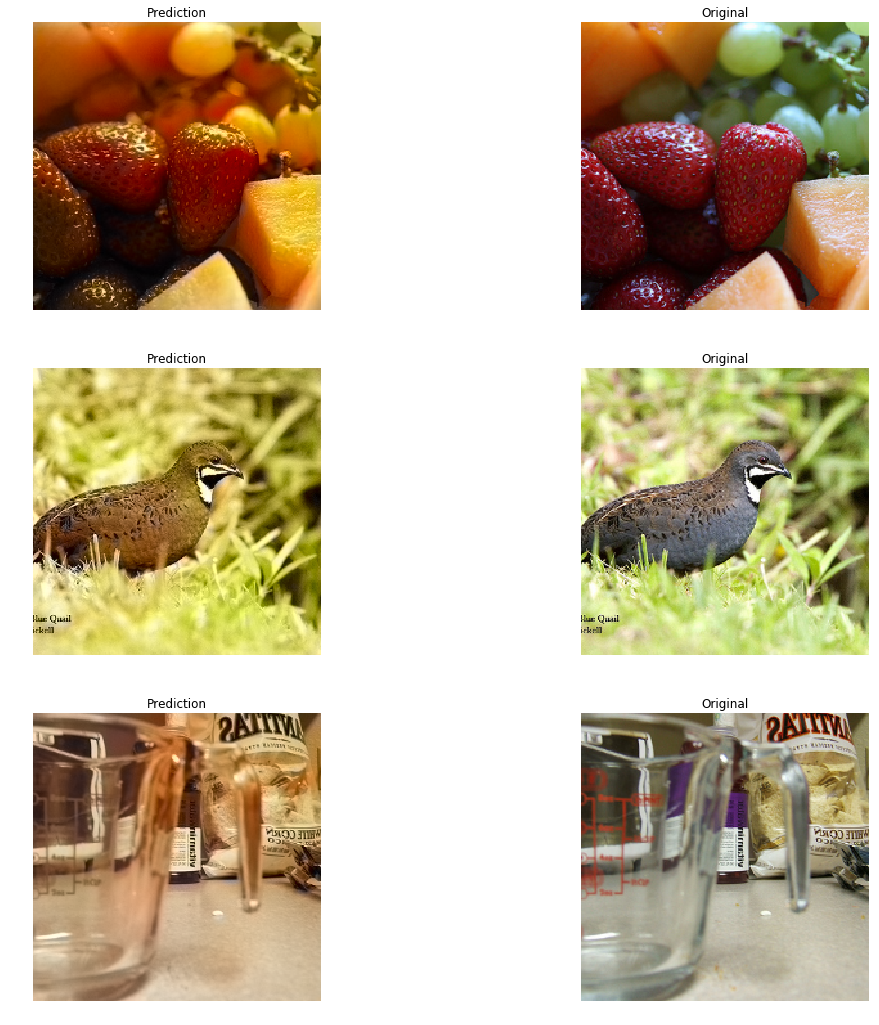

In [21]:
imagenet_step = 45000
exp_id = 'exp_reg_%s' % imagenet_step
collname = 'colorization'
dbname = 'assignment2'
target_layers = ['bn' + str(i) for i in range(1, 8)] + ['conv8_3', 'pred']
imagenet_data = get_colorization_validation_data(exp_id, collname, dbname)[-1]['validation_results']['colorization']

plt.figure(figsize=(18, 18))
for i in range(3):
        plt.subplot(3, 2, 2 * i + 1)
        plt.axis('off')
        plt.title('Prediction')
        plt.imshow(np.array(imagenet_data['pred'][i]))
        plt.subplot(3, 2, 2 * i + 2)
        plt.axis('off')
        plt.title('Original')
        plt.imshow(np.array(imagenet_data['gt'][i]))
plt.show()